# Calcualte performance rankings from cleaned results

In [1]:
# read cleaned results
import pandas as pd
from pathlib import Path
import pdb, os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

agg_df_with_default = pd.read_csv(Path("./cleaned_results/tuned_aggregated_results_with_default.csv"))
agg_df = pd.read_csv(Path("./cleaned_results/tuned_aggregated_results.csv"))

fold_df_with_default = pd.read_csv(Path("./cleaned_results/tuned_fold_results_with_default.csv"))
fold_df = pd.read_csv(Path("./cleaned_results/tuned_fold_results.csv"))

# make sure output folder exists
output_folder = Path("./performance_rankings")
output_folder.mkdir(exist_ok=True)  

In [2]:
import numpy as np

def get_rank_table(df, metric, table_idx=4):
    """
    NOTE: the df needs to have the following columns defined:
    - {metric}_rank_mean
    - normalized_{metric}__test_mean
    """
    if table_idx == 1:
        from analysis.table1 import DATASETS
    elif table_idx == 2:
        from analysis.table2 import DATASETS
    elif table_idx == 4:
        from analysis.table4 import DATASETS
    elif table_idx == 3:
        DATASETS =['openml__Bioresponse__9910',
        'openml__SpeedDating__146607',
        'openml__audiology__7',
        'openml__cnae-9__9981',
        'openml__guillermo__168337',
        'openml__jasmine__168911',
        'openml__nomao__9977',
        'openml__MiniBooNE__168335',
        'openml__airlines__189354',
        'openml__albert__189356',
        'openml__higgs__146606',
        'openml__poker-hand__9890']
        
    df = df[df["dataset_name"].isin(DATASETS)]

    overall_ranks = df.groupby("alg_name").agg(
        {
            f"{metric}_rank_mean": ["min", "max", "mean", "median", "count"],
            f"normalized_{metric}__test_mean": ["mean", "median"],
            f"normalized_{metric}__test_std": ["mean", "median"],
            f"time_per_1000_inst_mean_{metric}": ["mean", "median"],        
        }
    ).reset_index().sort_values([(f"{metric}_rank_mean", "mean")])

    # format min/max rank columns to be ints

    overall_ranks.loc[:, (f"{metric}_rank_mean", "count")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "count")].astype(int)

    # overall_ranks.loc[:, "alg_name"] = overall_ranks.loc[:, "alg_name"].apply(lambda x: "\rot{" + x + "}")
    overall_ranks.loc[:, (f"{metric}_rank_mean", "min")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "min")].apply(lambda x: "{:d}".format(int(x)))
    overall_ranks.loc[:, (f"{metric}_rank_mean", "max")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "max")].apply(lambda x: "{:d}".format(int(x)))

    # mean/median mean-rank
    overall_ranks.loc[:, (f"{metric}_rank_mean", "mean")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "mean")].apply(lambda x: "{:.2f}".format(x))
    overall_ranks.loc[:, (f"{metric}_rank_mean", "median")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "median")].apply(lambda x: "{:d}".format(int(x)) if int(x) == x else "{:.1f}".format(x))
    
    # normalized metric - mean and std over folds
    overall_ranks.loc[:, (f"normalized_{metric}__test_mean", "mean")] = overall_ranks.loc[:,(f"normalized_{metric}__test_mean", "mean")].apply(lambda x: "{:.2f}".format(x))
    overall_ranks.loc[:, (f"normalized_{metric}__test_mean", "median")] = overall_ranks.loc[:,(f"normalized_{metric}__test_mean", "median")].apply(lambda x: "{:.2f}".format(x))
    overall_ranks.loc[:, (f"normalized_{metric}__test_std", "mean")] = overall_ranks.loc[:,(f"normalized_{metric}__test_std", "mean")].apply(lambda x: "{:.2f}".format(x))
    overall_ranks.loc[:, (f"normalized_{metric}__test_std", "median")] = overall_ranks.loc[:,(f"normalized_{metric}__test_std", "median")].apply(lambda x: "{:.2f}".format(x))


    # normalized runtime
    overall_ranks.loc[:, (f"time_per_1000_inst_mean_{metric}", "mean")] = overall_ranks.loc[:,(f"time_per_1000_inst_mean_{metric}", "mean")].apply(lambda x: "{:.2f}".format(x))
    overall_ranks.loc[:, (f"time_per_1000_inst_mean_{metric}", "median")] = overall_ranks.loc[:,(f"time_per_1000_inst_mean_{metric}", "median")].apply(lambda x: "{:.2f}".format(x))
   


    final_table = overall_ranks.set_index("alg_name")

    return final_table


### Save rank tables to file

In [3]:
# save rank tables to csv and latex
from analysis_utils import ALG_DISPLAY_NAMES, ALG_TYPES
table_idx = 4

metric_list = [
    "Accuracy",
    "F1",
    "Log Loss",
    "AUC",
]

final_tables = {}

# best, worst, and average performance for each alg, over all datasets
for metric in metric_list:

    agg_df_with_default

    # first with default hparams as its own alg
    final_tables[metric] = get_rank_table(agg_df_with_default, metric, table_idx = table_idx)

    # save to csv, latex
    final_tables[metric].to_csv(output_folder / f"{metric}_rank_with_default.csv", index=True)
    final_tables[metric].to_latex(output_folder / f"{metric}_rank_with_default.tex", index=True, escape=False)

    # now without default hparams as its own alg
    final_tables[metric] = get_rank_table(agg_df, metric, table_idx=table_idx)

    # save to csv, latex
    final_tables[metric].to_csv(output_folder / f"{metric}_rank.csv", index=True)
    final_tables[metric].to_latex(output_folder / f"{metric}_rank.tex", index=True, escape=False)

/tmp/ipykernel_1783439/2973256359.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '1' '1' '1' '1' '1' '3' '1' '1' '1' '2' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '3' '7' '1' '3' '1' '9' '3' '1' '1' '1' '6' '6' '4'
 '4' '6' '5' '5' '14' '8' '6' '4' '3' '3' '8' '6' '5' '7' '8' '8' '9' '8'
 '19' '18' '33']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  overall_ranks.loc[:, (f"{metric}_rank_mean", "min")] = overall_ranks.loc[:, (f"{metric}_rank_mean", "min")].apply(lambda x: "{:d}".format(int(x)))
/tmp/ipykernel_1783439/2973256359.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['39' '50' '40' '49' '42' '46' '43' '47' '41' '51' '49' '37' '39' '49'
 '49' '53' '53' '46' '52' '56' '56' '46' '46' '48' '43' '49' '49' '49'
 '54' '57' '56' '56' '48' '49' '49' '49' '49' '48' '51' '54' '49

In [4]:
final_tables['AUC'].drop(['Ours-1', 'TabSmall', 'TabFast', 'TabFlex']).rename(index={'Ours-2': 'TabFlex'})

AUC_rank_mean                          \
                         min max   mean median count   
alg_name                                               
XGBoost                    1  23   5.42      2    36   
CatBoost                   1  22   6.14      4    35   
ResNet                     1  19   8.37      7    35   
LightGBM                   1  22   8.56    5.5    32   
RandomForest               1  25   9.20      7    35   
SAINT                      1  27   9.63      7    27   
HyperFast                  1  23  11.47     10    30   
TabFlex                    1  23  11.61   11.5    36   
TabPFN                     1  29  12.03   10.5    36   
NODE                       2  28  12.23     13    30   
FTTransformer              1  24  12.24     13    29   
DeepFM                     2  23  12.29     12    21   
MLP-rtdl                   1  26  12.31   11.5    36   
DANet                      2  24  12.37     12    27   
TabNet                     1  27  15.45     16    33   
TabTransformer             1  29  15.46   15.5    26   
SVM                        1  26  15.76     19    29   
STG                        1  28  16.58     18    31   
MLP                        4  27  16.75   17.5    36   
LinearModel                5  29  18.41   18.5    34   
TuneTables                 3  28  19.06     21    31   
DecisionTree               5  29  19.40     20    35   
KNN                        5  29  20.30     20    33   
VIME                       8  28  20.81   22.5    32   
NAM                       16  29  24.69   25.5    16   

               normalized_AUC__test_mean        normalized_AUC__test_std  \
                                    mean median                     mean   
alg_name                                                                   
XGBoost                             0.94   0.98                     0.08   
CatBoost                            0.93   0.96                     0.09   
ResNet                              0.87   0.91                     0.09   
LightGBM                            0.91   0.95                     0.11   
RandomForest                        0.86   0.88                     0.09   
SAINT                               0.80   0.91                     0.11   
HyperFast                           0.83   0.87                     0.10   
TabFlex                             0.73   0.87                     0.08   
TabPFN                              0.64   0.82                     0.11   
NODE                                0.81   0.88                     0.11   
FTTransformer                       0.79   0.86                     0.11   
DeepFM                              0.83   0.88                     0.12   
MLP-rtdl                            0.78   0.84                     0.09   
DANet                               0.86   0.90                     0.11   
TabNet                              0.77   0.85                     0.13   
TabTransformer                      0.68   0.80                     0.11   
SVM                                 0.76   0.78                     0.12   
STG                                 0.69   0.84                     0.13   
MLP                                 0.67   0.67                     0.11   
LinearModel                         0.57   0.78                     0.10   
TuneTables                          0.60   0.69                     0.15   
DecisionTree                        0.61   0.66                     0.12   
KNN                                 0.53   0.63                     0.13   
VIME                                0.58   0.49                     0.13   
NAM                                 0.45   0.53                     0.18   

                      time_per_1000_inst_mean_AUC          
               median                        mean  median  
alg_name                                                   
XGBoost          0.05                        1.82    0.29  
CatBoost         0.06                       51.02    1.47  
ResNet           

In [5]:
latex_table = final_tables['AUC'].drop(['Ours-1', 'TabSmall', 'TabFast', 'TabFlex']).drop(columns=['AUC_rank_mean']).rename(index={'Ours-2': 'TabFlex'})

# Add the 'class' column
latex_table.insert(0, ('class', ''), [ALG_TYPES.get(alg, '') for alg in latex_table.index])

# Reorder columns to show median before mean
columns = latex_table.columns.tolist()
for metric in ['normalized_AUC__test_mean', 'time_per_1000_inst_mean_AUC']:
    median_idx = columns.index((metric, 'median'))
    mean_idx = columns.index((metric, 'mean'))
    columns[median_idx], columns[mean_idx] = columns[mean_idx], columns[median_idx]
latex_table = latex_table[columns]

# Sort the table
latex_table = latex_table.sort_values([('normalized_AUC__test_mean', 'median'), ('time_per_1000_inst_mean_AUC', 'median')], ascending=[False, True])

latex_table


class normalized_AUC__test_mean        \
                                               median  mean   
alg_name                                                      
XGBoost                GBDT                      0.98  0.94   
CatBoost               GBDT                      0.96  0.93   
LightGBM               GBDT                      0.95  0.91   
ResNet                   NN                      0.91  0.87   
SAINT                    NN                      0.91  0.80   
DANet                    NN                      0.90  0.86   
RandomForest      Classical                      0.88  0.86   
NODE                     NN                      0.88  0.81   
DeepFM                   NN                      0.88  0.83   
TabFlex         Transformer                      0.87  0.73   
HyperFast                NN                      0.87  0.83   
FTTransformer   Transformer                      0.86  0.79   
TabNet          Transformer                      0.85  0.77   
STG                      NN                      0.84  0.69   
MLP-rtdl                 NN                      0.84  0.78   
TabPFN          Transformer                      0.82  0.64   
TabTransformer  Transformer                      0.80  0.68   
LinearModel       Classical                      0.78  0.57   
SVM               Classical                      0.78  0.76   
TuneTables      Transformer                      0.69  0.60   
MLP                      NN                      0.67  0.67   
DecisionTree      Classical                      0.66  0.61   
KNN               Classical                      0.63  0.53   
NAM                      NN                      0.53  0.45   
VIME                     NN                      0.49  0.58   

               normalized_AUC__test_std        time_per_1000_inst_mean_AUC  \
                                   mean median                      median   
alg_name                                                                     
XGBoost                            0.08   0.05                        0.29   
CatBoost                           0.09   0.06                        1.47   
LightGBM                           0.11   0.06                        0.45   
ResNet                             0.09   0.05                        5.38   
SAINT                              0.11   0.07                       67.94   
DANet                              0.11   0.08                       54.47   
RandomForest                       0.09   0.06                        0.33   
NODE                               0.11   0.09                      120.14   
DeepFM                             0.12   0.10                        4.88   
TabFlex                            0.08   0.05                        0.17   
HyperFast                          0.10   0.07                       29.03   
FTTransformer                      0.11   0.08                       13.59   
TabNet                             0.13   0.09                       26.83   
STG                                0.13   0.06                       15.45   
MLP-rtdl                           0.09   0.06                        4.31   
TabPFN                             0.11   0.07                        0.44   
TabTransformer                     0.11   0.09                       10.46   
LinearModel                        0.10   0.07                        0.02   
SVM                                0.12   0.07                        3.73   
TuneTables                         0.15   0.12                       19.94   
MLP                                0.11   0.06                        5.44   
DecisionTree                       0.12   0.10                        0.01   
KNN                                0.13   0.09                        0.04   
NAM                                0.18   0.13                       44.85   
VIME                               0.13   0.10                       16.51   

                        
                  mean  
alg_name              

In [6]:

print(latex_table.to_latex(float_format="%.3f",column_format='c'*len(latex_table.columns)))

\begin{tabular}{ccccccc}
\toprule
 & class & \multicolumn{2}{r}{normalized_AUC__test_mean} & \multicolumn{2}{r}{normalized_AUC__test_std} & \multicolumn{2}{r}{time_per_1000_inst_mean_AUC} \\
 &  & median & mean & mean & median & median & mean \\
alg_name &  &  &  &  &  &  &  \\
\midrule
XGBoost & GBDT & 0.98 & 0.94 & 0.08 & 0.05 & 0.29 & 1.82 \\
CatBoost & GBDT & 0.96 & 0.93 & 0.09 & 0.06 & 1.47 & 51.02 \\
LightGBM & GBDT & 0.95 & 0.91 & 0.11 & 0.06 & 0.45 & 1.28 \\
ResNet & NN & 0.91 & 0.87 & 0.09 & 0.05 & 5.38 & 7.97 \\
SAINT & NN & 0.91 & 0.80 & 0.11 & 0.07 & 67.94 & 123.06 \\
DANet & NN & 0.90 & 0.86 & 0.11 & 0.08 & 54.47 & 60.81 \\
RandomForest & Classical & 0.88 & 0.86 & 0.09 & 0.06 & 0.33 & 0.50 \\
NODE & NN & 0.88 & 0.81 & 0.11 & 0.09 & 120.14 & 126.69 \\
DeepFM & NN & 0.88 & 0.83 & 0.12 & 0.10 & 4.88 & 6.75 \\
TabFlex & Transformer & 0.87 & 0.73 & 0.08 & 0.05 & 0.17 & 0.42 \\
HyperFast & NN & 0.87 & 0.83 & 0.10 & 0.07 & 29.03 & 41.75 \\
FTTransformer & Transformer & 0.86 & 0.7

In [7]:
final_tables['AUC'][final_tables['AUC']['AUC_rank_mean']['count'] == 12]

Empty DataFrame
Columns: [(AUC_rank_mean, min), (AUC_rank_mean, max), (AUC_rank_mean, mean), (AUC_rank_mean, median), (AUC_rank_mean, count), (normalized_AUC__test_mean, mean), (normalized_AUC__test_mean, median), (normalized_AUC__test_std, mean), (normalized_AUC__test_std, median), (time_per_1000_inst_mean_AUC, mean), (time_per_1000_inst_mean_AUC, median)]
Index: []

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

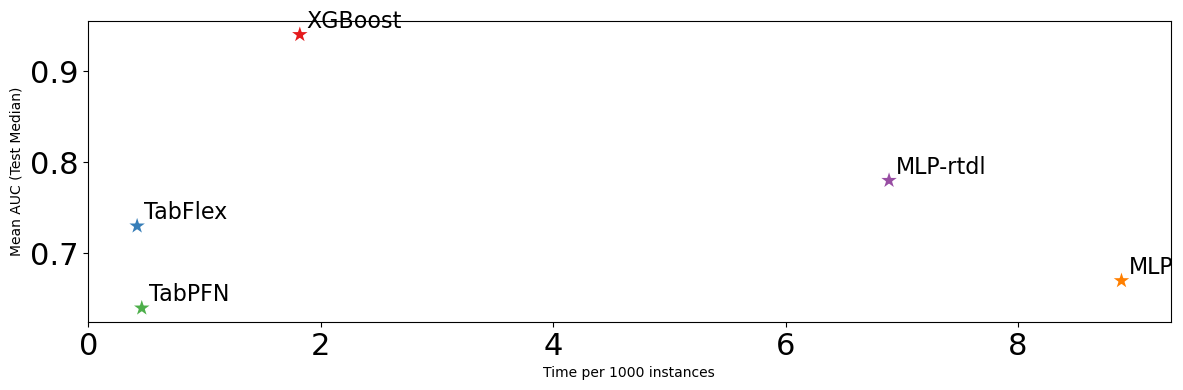

In [9]:
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)

# Filter the data for algorithms with count == 36
full_data = final_tables['AUC']
data_36 = full_data[full_data['AUC_rank_mean']['count'] == 36]
data_others = full_data[full_data['AUC_rank_mean']['count'] != 36]

# Create a DataFrame with the required columns, excluding specified algorithms
plot_data = pd.DataFrame({
    'Algorithm': full_data.index,
    'Time': full_data['time_per_1000_inst_mean_AUC']['mean'].astype(float),
    'AUC': full_data['normalized_AUC__test_mean']['mean'].astype(float),
    'Count': full_data['AUC_rank_mean']['count']
})
plot_data = plot_data[~plot_data['Algorithm'].isin(['Ours-1', 'TabFlex', 'TabSmall', 'TabFast'])]

# Change 'Ours-2' to 'TabFlex'
plot_data['Algorithm'] = plot_data['Algorithm'].replace('Ours-2', 'TabFlex')

# Create the scatter plot
plt.figure(figsize=(12, 4))

# # Plot other algorithms
# sns.scatterplot(data=plot_data[plot_data['Count'] != 36], 
#                 x='Time', y='AUC', 
#                 hue='Algorithm', 
#                 palette='Set2', alpha=0.7, s=100)

# Plot algorithms with count == 36 with different marker
sns.scatterplot(data=plot_data[plot_data['Count'] == 36], 
                x='Time', y='AUC', 
                hue='Algorithm', 
                palette='Set1', alpha=1, s=250, marker='*')

# Customize the plot
# plt.xscale('log')  # Use log scale for x-axis due to wide range of values
plt.xlabel('Time per 1000 instances')
plt.ylabel('Mean AUC (Test Median)')
# plt.ylim(0.4, 1)

# Add labels for each point
for _, row in plot_data[plot_data['Count'] == 36].iterrows():
    plt.annotate(row['Algorithm'], (row['Time'], row['AUC']),
                 xytext=(5, 5), textcoords='offset points', fontsize=16)

# Adjust legend
# plt.legend(
#     title='Algorithm', 
#     bbox_to_anchor=(1.05, 1),
#     loc='upper left',
#     ncol=2
# )

# remove the legend
plt.legend().remove()

plt.tight_layout()
plt.show()


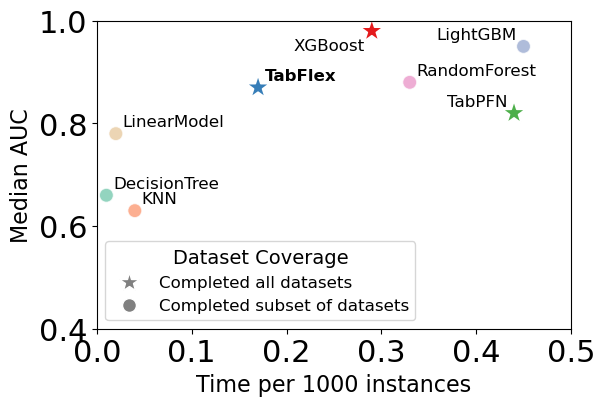

In [10]:
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)

# Filter the data for algorithms with count == 36
full_data = final_tables['AUC']
data_36 = full_data[full_data['AUC_rank_mean']['count'] == 36]
data_others = full_data[full_data['AUC_rank_mean']['count'] != 36]

# Create a DataFrame with the required columns, excluding specified algorithms
plot_data = pd.DataFrame({
    'Algorithm': full_data.index,
    'Time': full_data['time_per_1000_inst_mean_AUC']['median'].astype(float),
    'AUC': full_data['normalized_AUC__test_mean']['median'].astype(float),
    'Count': full_data['AUC_rank_mean']['count']
})
plot_data = plot_data[~plot_data['Algorithm'].isin(['Ours-1', 'TabFlex', 'TabSmall', 'TabFast'])]

# Change 'Ours-2' to 'TabFlex'
plot_data['Algorithm'] = plot_data['Algorithm'].replace('Ours-2', 'TabFlex')

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(left=0.16, bottom=.18, right=0.95, top=0.95, wspace=0.15, hspace = 0.3) #margin of the figure
fig.set_size_inches(6, 4) #exact size of the figure

# Plot other algorithms
sns.scatterplot(data=plot_data[plot_data['Count'] != 36], 
                x='Time', y='AUC', 
                hue='Algorithm', 
                palette='Set2', alpha=0.7, s=100)

# Plot algorithms with count == 36 with different marker
sns.scatterplot(data=plot_data[plot_data['Count'] == 36], 
                x='Time', y='AUC', 
                hue='Algorithm', 
                palette='Set1', alpha=1, s=350, marker='*')

# Customize the plot
# plt.xscale('log')  # Use log scale for x-axis due to wide range of values
plt.xlabel('Time per 1000 instances', fontsize=16)
plt.ylabel('Median AUC', fontsize=16)
plt.ylim(0.4, 1)
plt.xlim(0, .5)

# Add labels for each point
for _, row in plot_data.iterrows():
    if row['Algorithm'] == 'XGBoost':
        plt.annotate(row['Algorithm'], (row['Time'], row['AUC']),
                     xytext=(-5, -5), textcoords='offset points', fontsize=12, ha='right', va='top')
    elif row['Algorithm'] in ['TabPFN', 'LightGBM']:
        plt.annotate(row['Algorithm'], (row['Time'], row['AUC']),
                     xytext=(-5, 5), textcoords='offset points', fontsize=12, ha='right')
    elif row['Algorithm'] == 'TabFlex':
        plt.annotate(row['Algorithm'], (row['Time'], row['AUC']),
                     xytext=(5, 5), textcoords='offset points', fontsize=12, fontweight='bold')
    else:
        plt.annotate(row['Algorithm'], (row['Time'], row['AUC']),
                     xytext=(5, 5), textcoords='offset points', fontsize=12)

# Adjust legend
# Create custom legend handles
legend_elements = [
    plt.Line2D([0], [0], marker='*', color='w', label='Completed all datasets', 
               markerfacecolor='gray', markersize=15),
    plt.Line2D([0], [0], marker='o', color='w', label='Completed subset of datasets', 
               markerfacecolor='gray', markersize=10)
]

plt.legend(handles=legend_elements, title='Dataset Coverage', title_fontsize=14, fontsize=12)

plt.savefig(f"{root_dir}/figures/table4.pdf")


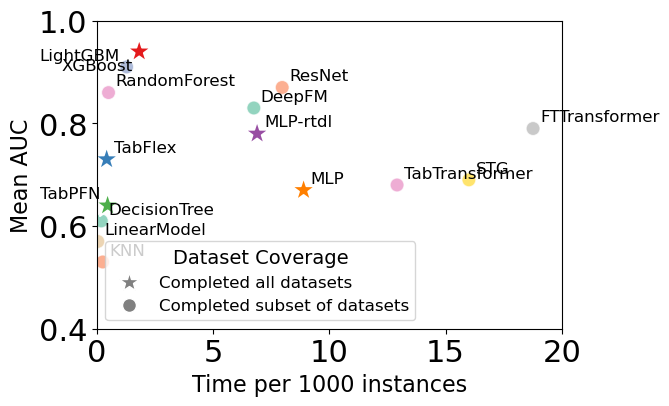

In [11]:
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)

# Filter the data for algorithms with count == 36
full_data = final_tables['AUC']
data_36 = full_data[full_data['AUC_rank_mean']['count'] == 36]
data_others = full_data[full_data['AUC_rank_mean']['count'] != 36]

# Create a DataFrame with the required columns, excluding specified algorithms
plot_data = pd.DataFrame({
    'Algorithm': full_data.index,
    'Time': full_data['time_per_1000_inst_mean_AUC']['mean'].astype(float),
    'AUC': full_data['normalized_AUC__test_mean']['mean'].astype(float),
    'Count': full_data['AUC_rank_mean']['count']
})
plot_data = plot_data[~plot_data['Algorithm'].isin(['Ours-1', 'TabFlex', 'TabSmall', 'TabFast'])]

# Change 'Ours-2' to 'TabFlex'
plot_data['Algorithm'] = plot_data['Algorithm'].replace('Ours-2', 'TabFlex')

# Create the scatter plot
plt.figure(figsize=(6, 4))

# Plot other algorithms
sns.scatterplot(data=plot_data[plot_data['Count'] != 36], 
                x='Time', y='AUC', 
                hue='Algorithm', 
                palette='Set2', alpha=0.7, s=100)

# Plot algorithms with count == 36 with different marker
sns.scatterplot(data=plot_data[plot_data['Count'] == 36], 
                x='Time', y='AUC', 
                hue='Algorithm', 
                palette='Set1', alpha=1, s=350, marker='*')

# Customize the plot
# plt.xscale('log')  # Use log scale for x-axis due to wide range of values
plt.xlabel('Time per 1000 instances', fontsize=16)
plt.ylabel('Mean AUC', fontsize=16)
plt.ylim(0.4, 1)
plt.xlim(0, 20)

# Add labels for each point
for _, row in plot_data.iterrows():
    if row['Algorithm'] == 'XGBoost':
        plt.annotate(row['Algorithm'], (row['Time'], row['AUC']),
                     xytext=(-5, -5), textcoords='offset points', fontsize=12, ha='right', va='top')
    elif row['Algorithm'] in ['TabPFN', 'LightGBM']:
        plt.annotate(row['Algorithm'], (row['Time'], row['AUC']),
                     xytext=(-5, 5), textcoords='offset points', fontsize=12, ha='right')
    else:
        plt.annotate(row['Algorithm'], (row['Time'], row['AUC']),
                     xytext=(5, 5), textcoords='offset points', fontsize=12)

# Adjust legend
# Create custom legend handles
legend_elements = [
    plt.Line2D([0], [0], marker='*', color='w', label='Completed all datasets', 
               markerfacecolor='gray', markersize=15),
    plt.Line2D([0], [0], marker='o', color='w', label='Completed subset of datasets', 
               markerfacecolor='gray', markersize=10)
]

plt.legend(handles=legend_elements, title='Dataset Coverage', title_fontsize=14, fontsize=12)

plt.show()
